In [70]:
import time
import joblib
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import darts
import shap
from pandas_profiling import ProfileReport
from statsmodels.graphics.tsaplots import plot_acf
from darts import TimeSeries
from darts.models import KalmanFilter, RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
from darts.utils import timeseries_generation as tg
from datetime import datetime as dt
from datetime import timedelta, timezone
from scipy.signal import lombscargle, periodogram
%matplotlib inline

In [3]:
# pip install joblib

In [4]:
HDeviceCGM = pd.read_csv('../data/REPLACE-BG/data_tables/HDeviceCGM.txt', sep='|', index_col=False) 

In [5]:
# describe and report missing data

# distributions --> log normal?

# cross correlation function
glucose_values = HDeviceCGM['GlucoseValue']


HDeviceCGM.head(10000)

##

,RecID,ParentHDeviceUploadsID,PtID,SiteID,DeviceDtTmDaysFromEnroll,DeviceTm,DexInternalDtTmDaysFromEnroll,DexInternalTm,RecordType,GlucoseValue
0,1655236,782,183,12,-6,05:35:41,-6.0,12:37:02,CGM,162.0
1,1655237,782,183,12,-6,05:30:41,-6.0,12:32:02,CGM,164.0
2,1655238,782,183,12,-6,05:25:41,-6.0,12:27:02,CGM,168.0
3,1655239,782,183,12,-6,05:20:41,-6.0,12:22:02,CGM,169.0
4,1655240,782,183,12,-6,05:15:41,-6.0,12:17:02,CGM,170.0
...,...,...,...,...,...,...,...,...,...,...
9995,15250028,9916,184,9,159,20:11:59,160.0,03:07:45,CGM,189.0
9996,15250029,9916,184,9,159,20:06:59,160.0,03:02:45,CGM,191.0
9997,15250030,9916,184,9,159,20:01:59,160.0,02:57:45,CGM,190.0
9998,15250031,9916,184,9,159,19:56:59,160.0,02:52:45,CGM,190.0


In [6]:
HDeviceCGM.describe()

,RecID,ParentHDeviceUploadsID,PtID,SiteID,DeviceDtTmDaysFromEnroll,DexInternalDtTmDaysFromEnroll,GlucoseValue
count,1.495066e+07,1.495066e+07,1.495066e+07,1.495066e+07,1.495066e+07,1.435789e+07,1.495066e+07
mean,7.616951e+06,5.784978e+03,1.477633e+02,8.276100e+00,1.070591e+02,9.752153e+01,1.603617e+02
std,4.447060e+06,3.168884e+03,8.531525e+01,4.412503e+00,8.177121e+01,1.007653e+02,6.467256e+01
min,1.000000e+00,4.000000e+00,2.000000e+00,1.000000e+00,-6.030000e+02,-4.560000e+02,2.500000e+01
25%,3.737666e+06,3.022000e+03,7.200000e+01,5.000000e+00,4.400000e+01,3.600000e+01,1.120000e+02
50%,7.475331e+06,5.966000e+03,1.470000e+02,8.000000e+00,1.070000e+02,1.000000e+02,1.500000e+02
75%,1.151821e+07,8.652000e+03,2.230000e+02,1.200000e+01,1.720000e+02,1.690000e+02,1.980000e+02
max,1.525588e+07,1.104000e+04,2.930000e+02,1.500000e+01,3.290000e+02,6.230000e+02,6.000000e+02


In [7]:
HDeviceCGM.dtypes

RecID                              int64
ParentHDeviceUploadsID             int64
PtID                               int64
SiteID                             int64
DeviceDtTmDaysFromEnroll           int64
DeviceTm                          object
DexInternalDtTmDaysFromEnroll    float64
DexInternalTm                     object
RecordType                        object
GlucoseValue                     float64
dtype: object

In [8]:
HDeviceCGM['GlucoseValue'].isnull().any()

False

In [9]:
# helper functions 
#todo: refactor this to helper modules
MINUTES_PER_DAY = 1440.0

def _get_corrected_minutes(uncorrected_total_minutes, minimum_internal_day): 
    return uncorrected_total_minutes - minimum_internal_day*MINUTES_PER_DAY  

def _to_unique_minutes_per_row(row, mininmum_internal_day): 
    time_string = row['DexInternalTm']
    day = row['DexInternalDtTmDaysFromEnroll']
    x = time.strptime(time_string, "%H:%M:%S")
    total_minutes = timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()/60 + day*MINUTES_PER_DAY
    return _get_corrected_minutes(total_minutes, mininmum_internal_day)

def add_internal_date_time_features(df): 
    minimum_internal_day = df['DexInternalDtTmDaysFromEnroll'].min()
    print("NOTE: The following warning is a false positive according to: https://www.dataquest.io/blog/settingwithcopywarning/")
    df['TotalInternalMinutes'] = df.apply(lambda x: _to_unique_minutes_per_row(x, minimum_internal_day), axis=1)
    df['InternalDateTime'] =  df['TotalInternalMinutes'].apply(lambda x: pd.to_datetime(x, unit='m'))
    df = df.set_index('InternalDateTime')
    df = df.sort_values(by='TotalInternalMinutes', ascending=True, na_position='first')
    df['TotalInternalHours_Diff'] = abs(df['TotalInternalMinutes'].diff() / 60)
    return df

In [10]:
print(len(HDeviceCGM))
print(HDeviceCGM['RecordType'].unique())
CGM =  HDeviceCGM[HDeviceCGM['RecordType'] == "CGM"]
pt183 = CGM[CGM['PtID'] == 183]
pt184 = CGM[CGM['PtID'] == 184]
pt185 = CGM[CGM['PtID'] == 185]
pt186 = CGM[CGM['PtID'] == 186]

14950661
['CGM' 'Calibration']


In [11]:
pt183 = add_internal_date_time_features(pt183)
pt184 = add_internal_date_time_features(pt184)
pt185 = add_internal_date_time_features(pt185)
pt186 = add_internal_date_time_features(pt186)

NOTE: The following warning is a false positive according to: https://www.dataquest.io/blog/settingwithcopywarning/



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NOTE: The following warning is a false positive according to: https://www.dataquest.io/blog/settingwithcopywarning/



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NOTE: The following warning is a false positive according to: https://www.dataquest.io/blog/settingwithcopywarning/



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


NOTE: The following warning is a false positive according to: https://www.dataquest.io/blog/settingwithcopywarning/



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [12]:
pt184.head(100)

,RecID,ParentHDeviceUploadsID,PtID,SiteID,DeviceDtTmDaysFromEnroll,DeviceTm,DexInternalDtTmDaysFromEnroll,DexInternalTm,RecordType,GlucoseValue,TotalInternalMinutes,TotalInternalHours_Diff
InternalDateTime,,,,,,,,,,,,
1970-01-01 22:35:00,15199670,4468,184,9,0,14:34:59,0.0,22:35:00,CGM,105.0,1355.000000,NaN
1970-01-01 22:40:00,15199669,4468,184,9,0,14:39:59,0.0,22:40:00,CGM,107.0,1360.000000,0.083333
1970-01-01 22:45:00,15199668,4468,184,9,0,14:44:59,0.0,22:45:00,CGM,105.0,1365.000000,0.083333
1970-01-01 22:50:00,15199667,4468,184,9,0,14:49:59,0.0,22:50:00,CGM,111.0,1370.000000,0.083333
1970-01-01 22:55:00,15199666,4468,184,9,0,14:54:59,0.0,22:55:00,CGM,112.0,1375.000000,0.083333
...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-02 06:29:58,15244061,4468,184,9,0,22:29:58,1.0,06:29:58,CGM,166.0,1829.966667,0.083333
1970-01-02 06:34:58,15244060,4468,184,9,0,22:34:58,1.0,06:34:58,CGM,168.0,1834.966667,0.083333
1970-01-02 06:39:58,15244059,4468,184,9,0,22:39:58,1.0,06:39:58,CGM,170.0,1839.966667,0.083333


[4468]


<AxesSubplot:xlabel='TotalInternalMinutes', ylabel='GlucoseValue'>

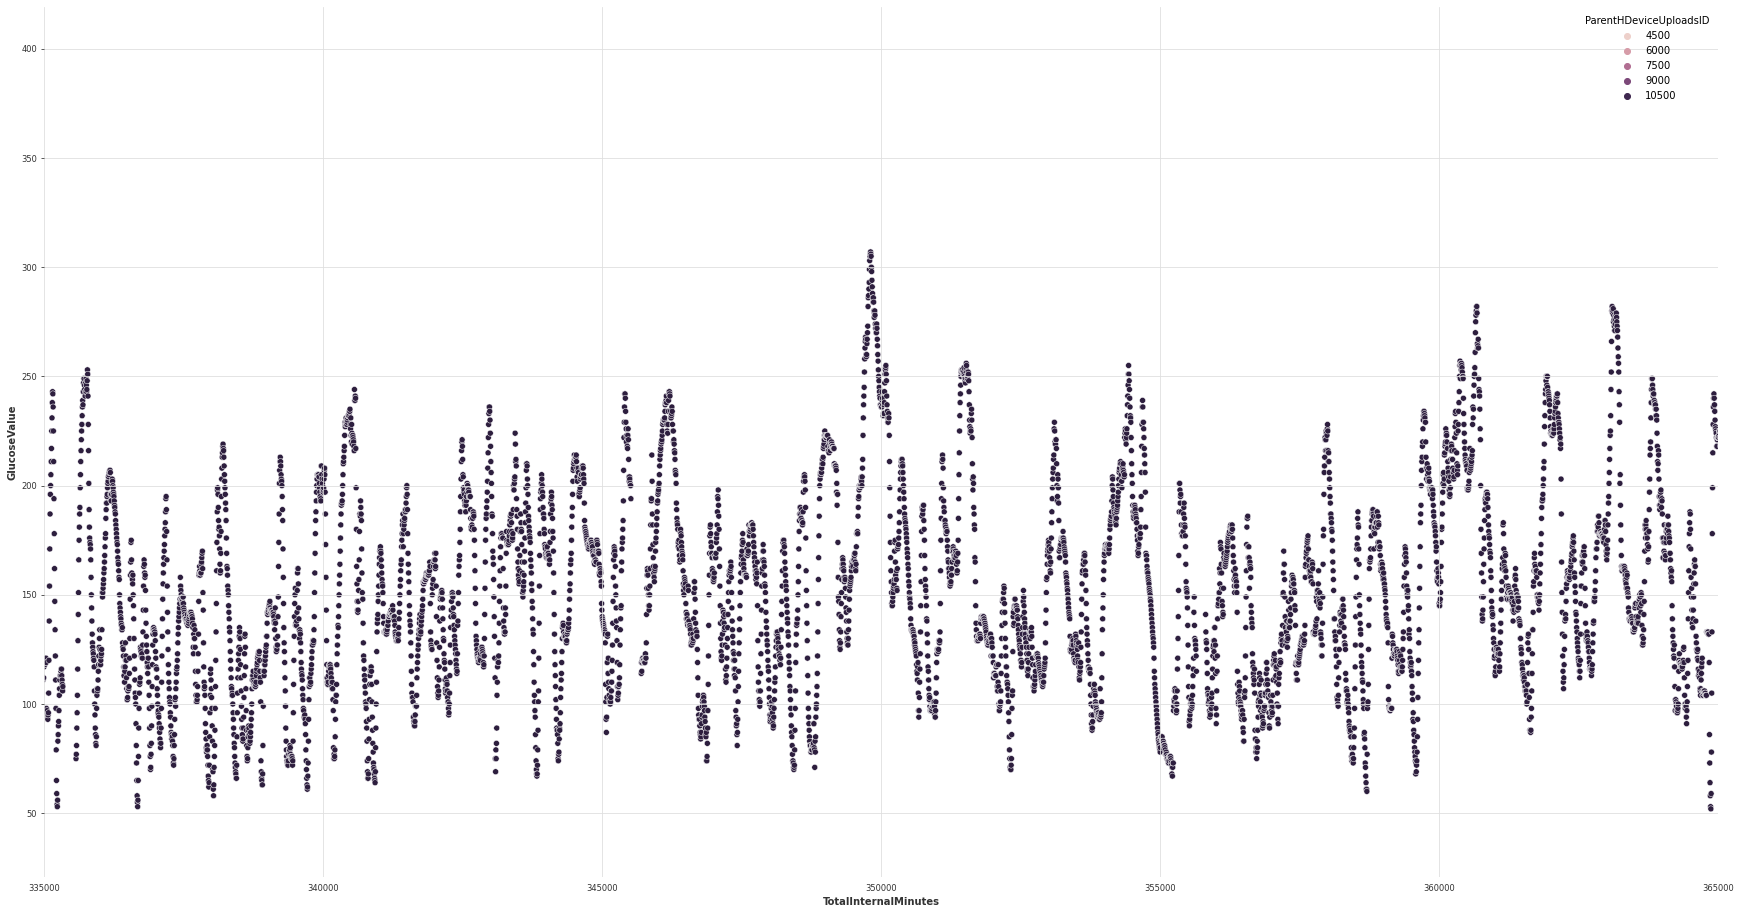

In [13]:
plt.figure(figsize=(30,16))
plt.xlim(335000, 365000)
sns.scatterplot(data=pt184, x="TotalInternalMinutes", y="GlucoseValue", hue="ParentHDeviceUploadsID")

<AxesSubplot:xlabel='TotalInternalMinutes', ylabel='TotalInternalHours_Diff'>

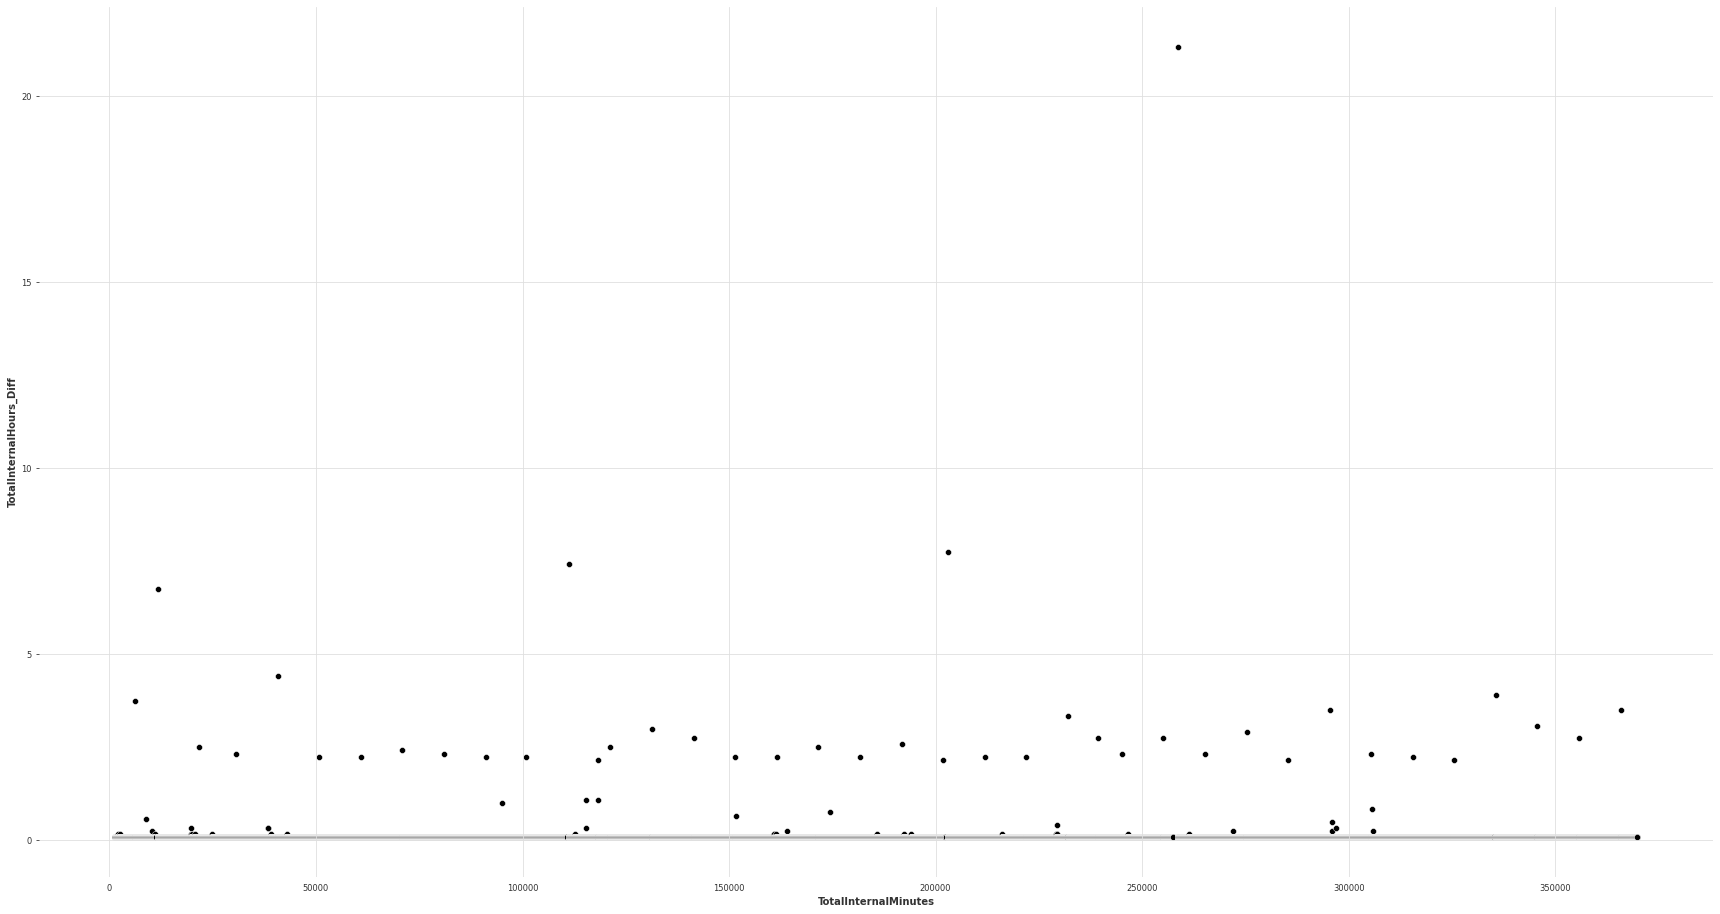

In [14]:
plt.figure(figsize=(30,16))
sns.scatterplot(data=pt184, x="TotalInternalMinutes", y="TotalInternalHours_Diff")

In [81]:
pt184_copy = pt184.copy()
print(pt184_copy.index[0])
print(pt184_copy.index[-1])
print(len(pt184_copy))
pt184_copy = pt184_copy.drop(
    columns=[
        'ParentHDeviceUploadsID',
        'RecID', 
        'PtID',
        'DeviceTm',
        'DexInternalDtTmDaysFromEnroll',
        'DexInternalTm',
        'RecordType', 
        'TotalInternalHours_Diff',
        'SiteId',
        'DeviceDtTmDaysFromEnroll',
        'SiteID'],
    errors="ignore")

pt184_copy = pt184_copy.resample('s').interpolate(method="spline", order=1).resample('5T').interpolate(method="nearest")

1970-01-01 22:35:00
1970-09-14 19:00:23
71918


In [82]:
pt184_copy.head(100)

,GlucoseValue,TotalInternalMinutes
InternalDateTime,,
1970-01-01 22:35:00,105.000000,1355.0
1970-01-01 22:40:00,107.000000,1360.0
1970-01-01 22:45:00,105.000000,1365.0
1970-01-01 22:50:00,111.000000,1370.0
1970-01-01 22:55:00,112.000000,1375.0
...,...,...
1970-01-02 06:30:00,167.077628,1830.0
1970-01-02 06:35:00,168.453399,1835.0
1970-01-02 06:40:00,169.829169,1840.0


       GlucoseValue  TotalInternalMinutes  TotalInternalHours_Diff
count  73686.000000          73686.000000             7.368500e+04
mean     151.340276         185567.500000             8.333333e-02
std       49.350521         106357.301524             6.679524e-13
min       40.266599           1355.000000             8.333333e-02
25%      114.748413          93461.250000             8.333333e-02
50%      145.245580         185567.500000             8.333333e-02
75%      182.016305         277673.750000             8.333333e-02
max      401.538032         369780.000000             8.333333e-02


<AxesSubplot:xlabel='TotalInternalMinutes', ylabel='TotalInternalHours_Diff'>

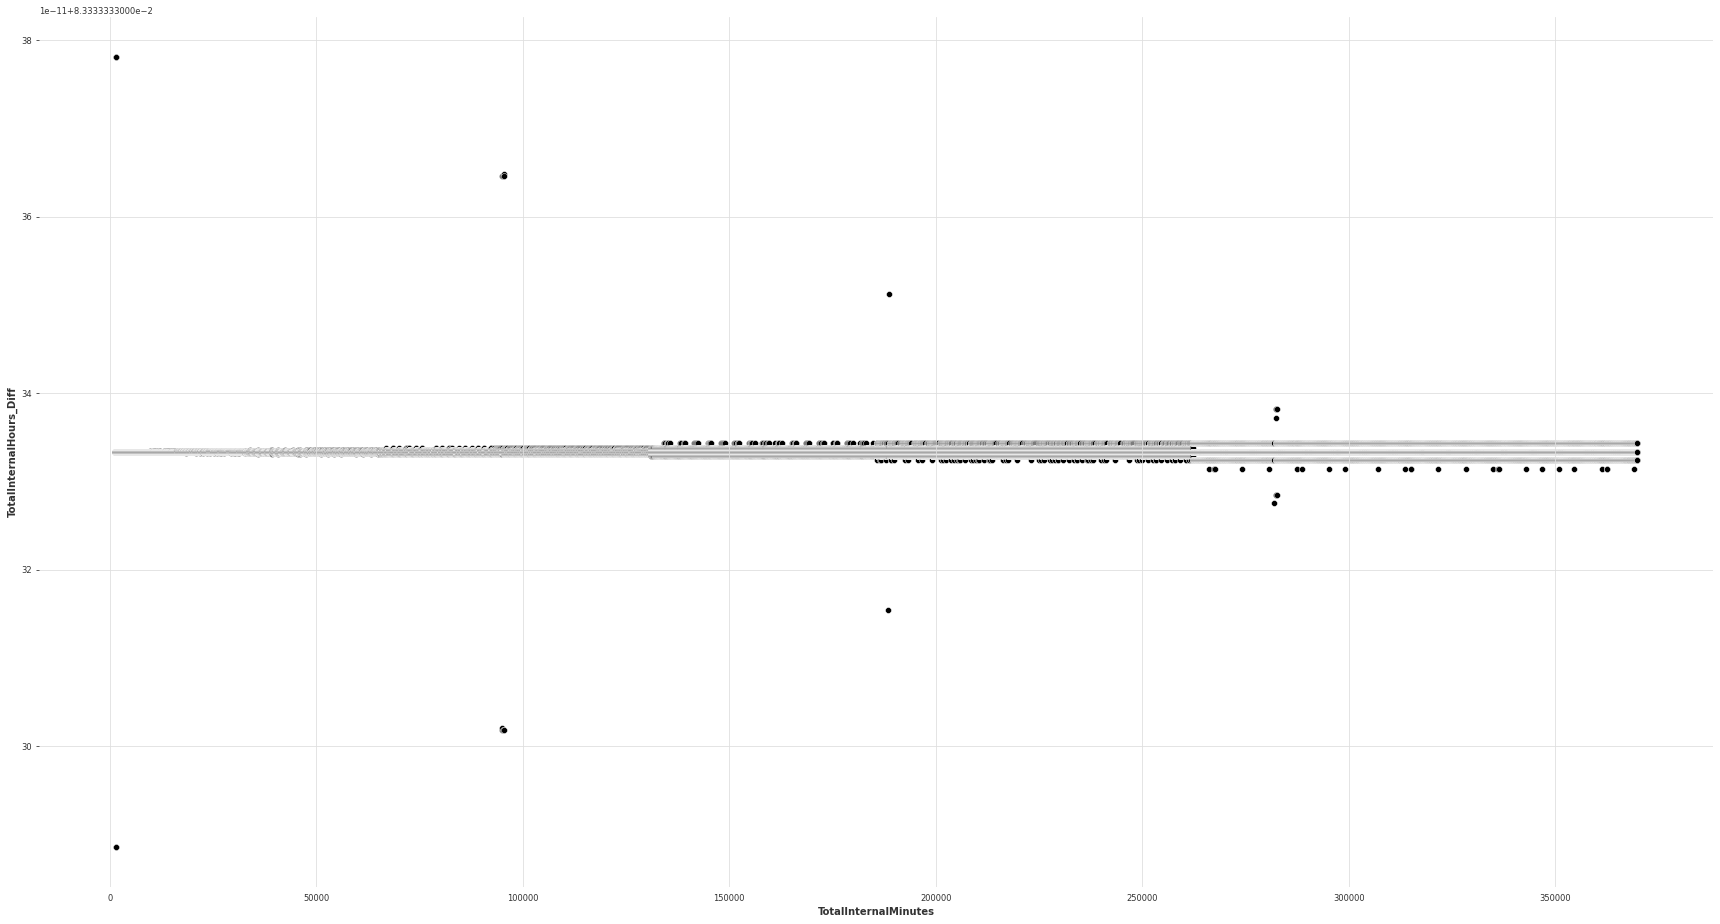

In [83]:
pt184_copy = pt184_copy.sort_values(by='TotalInternalMinutes', ascending=True, na_position='first')
pt184_copy['TotalInternalHours_Diff'] = abs(pt184_copy['TotalInternalMinutes'].diff() / 60)
print(pt184_copy.describe())
plt.figure(figsize=(30,16))
sns.scatterplot(data=pt184_copy, x="TotalInternalMinutes", y="TotalInternalHours_Diff")

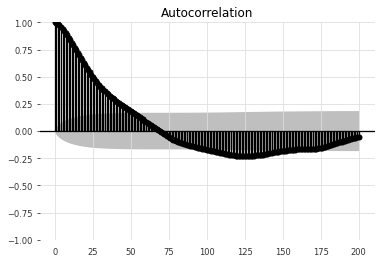

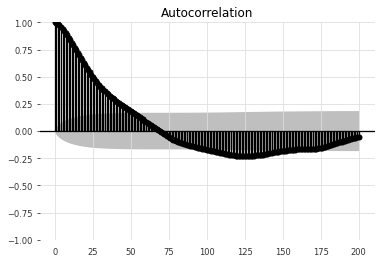

In [84]:
plot_acf(pt184_copy['GlucoseValue'].head(5000), lags=200)

In [85]:
pt184_copy['GlucoseValue'].isna().values.any()

False

In [86]:
pt184_copy.head(100)

,GlucoseValue,TotalInternalMinutes,TotalInternalHours_Diff
InternalDateTime,,,
1970-01-01 22:35:00,105.000000,1355.0,NaN
1970-01-01 22:40:00,107.000000,1360.0,0.083333
1970-01-01 22:45:00,105.000000,1365.0,0.083333
1970-01-01 22:50:00,111.000000,1370.0,0.083333
1970-01-01 22:55:00,112.000000,1375.0,0.083333
...,...,...,...
1970-01-02 06:30:00,167.077628,1830.0,0.083333
1970-01-02 06:35:00,168.453399,1835.0,0.083333
1970-01-02 06:40:00,169.829169,1840.0,0.083333


Text(0.5, 0, 'Frequency (Hz)')

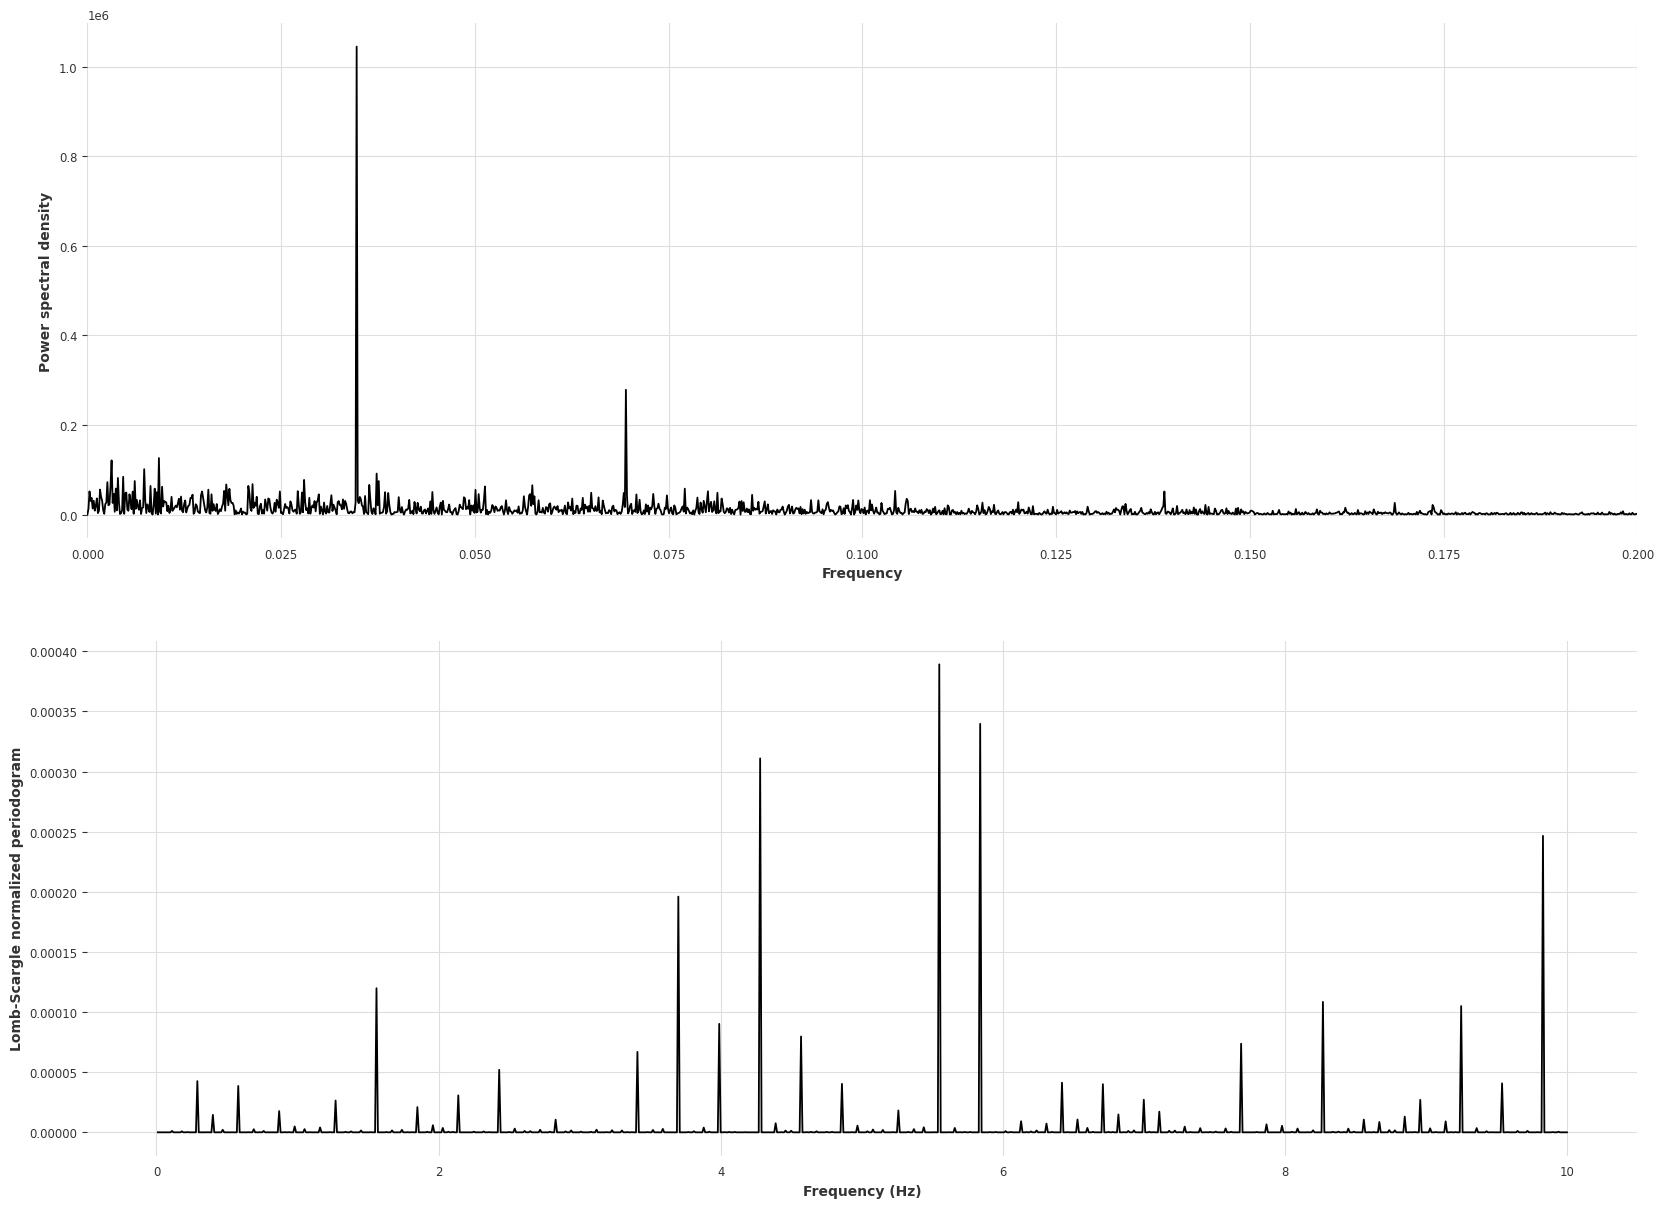

In [87]:
import signal 
fig, ax_list = plt.subplots(2,1, figsize=(20, 15), dpi=100)

input_signal = pt184_copy['GlucoseValue'].values
t_steps = pt184_copy.index.values

# fig 3
ax=ax_list[0]
f, Pxx_den = periodogram(input_signal, fs=10)
ax.set_xlim(0, 0.2) # keep our periodogram between 0 and nyquist 
ax.plot(f, Pxx_den)
ax.set_ylabel('Power spectral density')
ax.set_xlabel('Frequency')


# fig 4
# Plot Lomb-Scargle spectrogram of input signal
ax = ax_list[1]
f = np.linspace(0.01, 10, 1000)
pgram = lombscargle(t_steps, input_signal, f, normalize=True)
ax.plot(f, pgram)
ax.set_ylabel("Lomb-Scargle normalized periodogram")
ax.set_xlabel('Frequency (Hz)')
# plt.savefig('periodogram_plot_evendata.png', dpi=300, bbox_inches='tight')

In [88]:
pt184_timeseries = TimeSeries.from_dataframe(pt184_copy.head(200000), value_cols = ['GlucoseValue']) # we run out of memory if we train on more samples
len(pt184_copy)

73686

In [89]:
kf = KalmanFilter(dim_x=2)
kf.fit(pt184_timeseries.head(100))
y_filtered = kf.filter(pt184_timeseries)
pt184_copy['GlucoseValue_kalman_filtered'] = y_filtered.pd_series()

<Figure size 2160x1152 with 0 Axes>

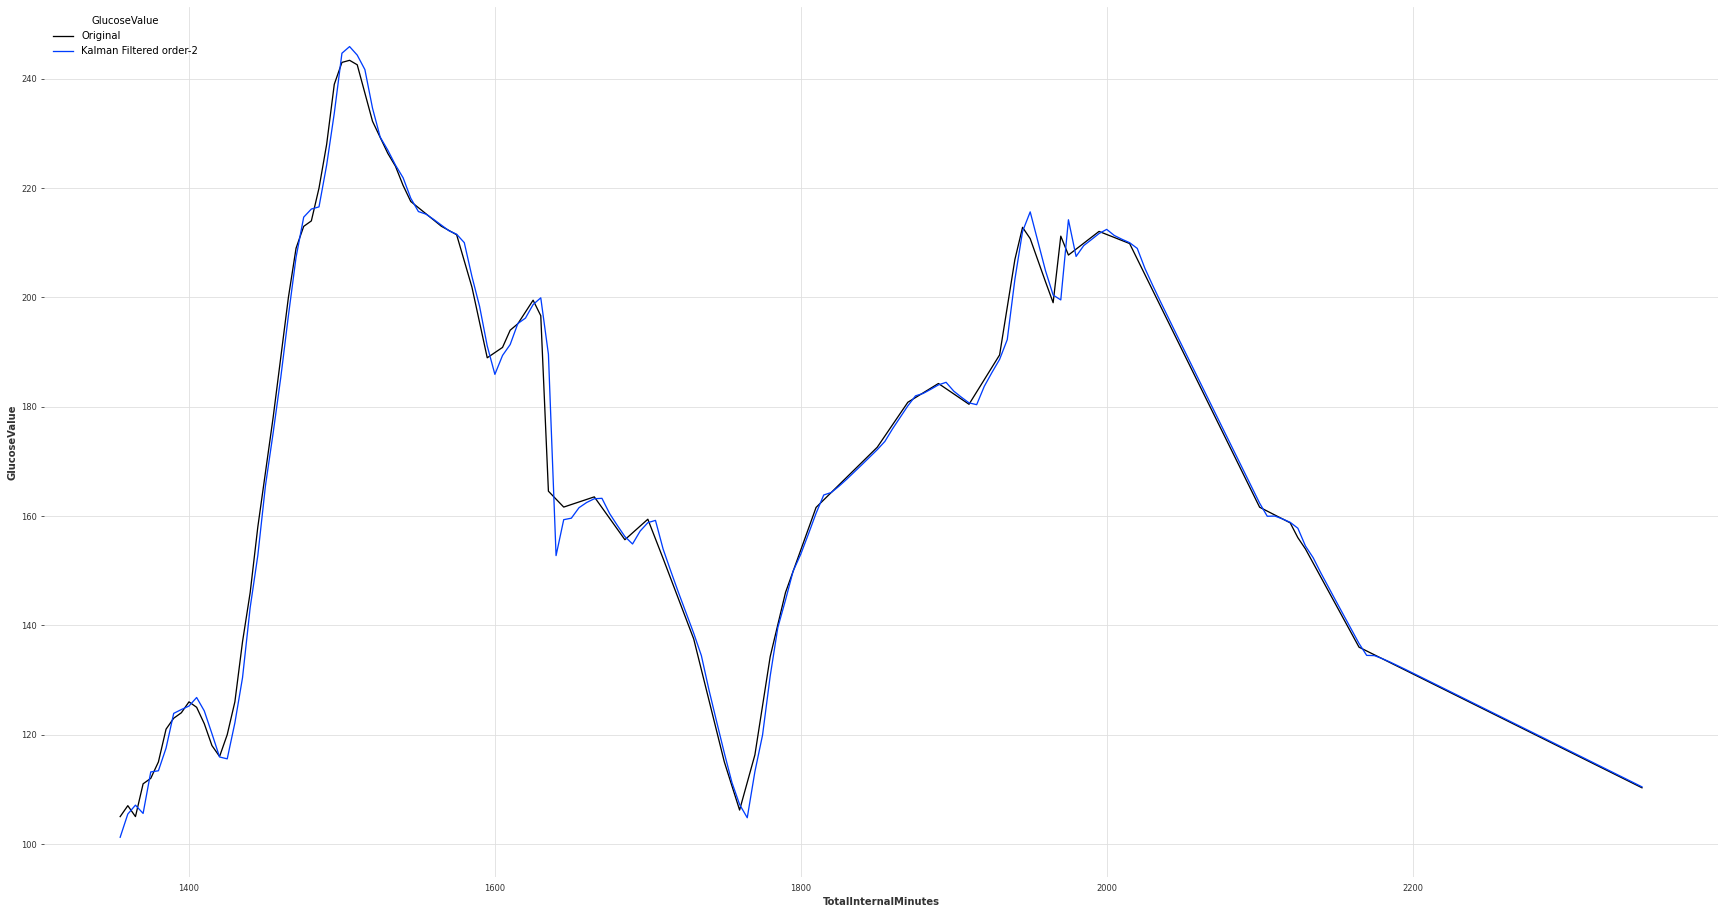

In [90]:
plt.figure(figsize=(30,16))
fig, ax = plt.subplots(figsize=(30,16))
sns.lineplot(data=pt184_copy.head(200), x="TotalInternalMinutes", y="GlucoseValue", ax=ax)
sns.lineplot(data=pt184_copy.head(200), x="TotalInternalMinutes", y="GlucoseValue_kalman_filtered", ax=ax)
plt.legend(title='GlucoseValue', loc='upper left', labels=['Original', 'Kalman Filtered order-2'])

In [ ]:
nbeats_model = NBEATSModel(input_chunk_length=2000, output_chunk_length=30, n_epochs=30)
nbeats_model.fit(pt184_timeseries.head(25000))
pt184_timeseries

[2022-05-01 21:35:01,363] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 22971 samples.
[2022-05-01 21:35:01,363] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 22971 samples.
2022-05-01 21:35:01 darts.models.forecasting.torch_forecasting_model INFO: Train dataset contains 22971 samples.
[2022-05-01 21:35:01,475] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-05-01 21:35:01,475] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
2022-05-01 21:35:01 darts.models.forecasting.torch_forecasting_model INFO: Time series values are 64-bits; casting model to float64.
2022-05-01 21:35:01 pytorch_lightning.utilities.rank_zero INFO: GPU available: False, used: False
2022-05-01 21:35:01 pytorch_lightning.utilities.rank_zero INFO: TPU available: False, using: 0 TPU cores
2022-05-01 21:35:01 pyt

Training: 0it [00:00, ?it/s]

In [71]:
# problems: 
    # glucose value is capped at 400! should we impute those values? 
    # smoothing and/or fft? 
# todo's: 
    # add test/train split
    # add test metrics
    # explainability? shap scores? 
    # add scaling if we end up doing multivariate prediction
# ideas: 
    # predict on time of day? (device time
    


InternalDateTime
1970-01-01 22:35:00    104.833918
1970-01-01 22:36:00    104.848747
1970-01-01 22:37:00    105.125536
1970-01-01 22:38:00    105.480504
1970-01-01 22:39:00    105.845748
                          ...    
1970-01-02 15:10:00    110.403428
1970-01-02 15:11:00    110.236752
1970-01-02 15:12:00    110.039064
1970-01-02 15:13:00    109.826141
1970-01-02 15:14:00    109.610022
Freq: T, Name: GlucoseValue_kalman_filtered, Length: 1000, dtype: float64

In [69]:
input_signal

array([104.8339175 , 104.84874736, 105.12553581, ...,          nan,
                nan,          nan])